# Regresión RSAM Seq-to-Seq

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GRU, Dense, 
    Dropout, BatchNormalization, RepeatVector, TimeDistributed
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Carga de Datos

In [2]:
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

with open(PROCESSED_DIR / 'rsam_metadata.json') as f:
    metadata = json.load(f)

RSAM_MEAN = metadata['rsam_mean']
RSAM_STD = metadata['rsam_std']
RSAM_PER_HOUR = metadata['rsam_per_hour']

print(f"Parámetros de normalización:")
print(f"  Media: {RSAM_MEAN:.2f}")
print(f"  Std: {RSAM_STD:.2f}")
print(f"  Valores por hora: {RSAM_PER_HOUR}")

Parámetros de normalización:
  Media: 64177.58
  Std: 19713.28
  Valores por hora: 6


In [3]:
CONFIG_NAMES = ['short', 'medium', 'long']
datasets = {}

for config in CONFIG_NAMES:
    data = np.load(PROCESSED_DIR / f'rsam_{config}_seq2seq.npz')
    datasets[config] = {
        'X_train': data['X_train'],
        'X_val': data['X_val'],
        'X_test': data['X_test'],
        'y_train': data['y_train'],
        'y_val': data['y_val'],
        'y_test': data['y_test'],
        'input_steps': data['X_train'].shape[1],
        'output_steps': data['y_train'].shape[1]
    }
    
    print(f"\nConfiguración: {config.upper()}")
    print(f"  Input: {datasets[config]['input_steps']} pasos ({datasets[config]['input_steps']//RSAM_PER_HOUR}h)")
    print(f"  Output: {datasets[config]['output_steps']} pasos ({datasets[config]['output_steps']//RSAM_PER_HOUR}h)")
    print(f"  X_train: {datasets[config]['X_train'].shape}")
    print(f"  y_train: {datasets[config]['y_train'].shape}")


Configuración: SHORT
  Input: 72 pasos (12h)
  Output: 18 pasos (3h)
  X_train: (6122, 72, 1)
  y_train: (6122, 18)

Configuración: MEDIUM
  Input: 144 pasos (24h)
  Output: 36 pasos (6h)
  X_train: (6111, 144, 1)
  y_train: (6111, 36)

Configuración: LONG
  Input: 288 pasos (48h)
  Output: 72 pasos (12h)
  X_train: (6090, 288, 1)
  y_train: (6090, 72)


## 2. Funciones Auxiliares

In [4]:
def calculate_metrics_seq(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    metrics = {}
    metrics['rmse_norm'] = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    metrics['mae_norm'] = mean_absolute_error(y_true_flat, y_pred_flat)
    metrics['r2'] = r2_score(y_true_flat, y_pred_flat)
    
    y_true_orig = y_true_flat * RSAM_STD + RSAM_MEAN
    y_pred_orig = y_pred_flat * RSAM_STD + RSAM_MEAN
    
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    metrics['mae'] = mean_absolute_error(y_true_orig, y_pred_orig)
    
    mask = y_true_orig != 0
    if mask.sum() > 0:
        metrics['mape'] = np.mean(np.abs((y_true_orig[mask] - y_pred_orig[mask]) / y_true_orig[mask])) * 100
    else:
        metrics['mape'] = np.nan
    
    return metrics

def print_metrics(metrics, model_name="Modelo"):
    print(f"\n{'='*50}")
    print(f"MÉTRICAS - {model_name}")
    print(f"{'='*50}")
    print(f"  RMSE (original):     {metrics['rmse']:,.2f}")
    print(f"  MAE (original):      {metrics['mae']:,.2f}")
    print(f"  MAPE:                {metrics['mape']:.2f}%")
    print(f"  R²:                  {metrics['r2']:.4f}")
    print(f"  RMSE (normalizado):  {metrics['rmse_norm']:.4f}")
    print(f"  MAE (normalizado):   {metrics['mae_norm']:.4f}")

print("Funciones definidas")

Funciones definidas


In [5]:
def build_seq2seq_cnn_gru(input_steps, output_steps, n_features=1,
                          n_filters=64, kernel_size=3, 
                          encoder_units=64, decoder_units=64,
                          n_conv_layers=2, dropout_rate=0.2):
    inputs = Input(shape=(input_steps, n_features), name='input')
    
    x = inputs
    for i in range(n_conv_layers):
        filters = n_filters * (2**i)
        x = Conv1D(filters=filters, kernel_size=kernel_size,
                   activation='relu', padding='same', 
                   name=f'encoder_conv_{i+1}')(x)
        x = BatchNormalization(name=f'encoder_bn_{i+1}')(x)
        x = MaxPooling1D(pool_size=2, name=f'encoder_pool_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'encoder_dropout_conv_{i+1}')(x)
    
    encoder_output = GRU(encoder_units, return_sequences=False, 
                         name='encoder_gru')(x)
    encoder_output = Dropout(dropout_rate, name='encoder_dropout_gru')(encoder_output)
    
    decoder_input = RepeatVector(output_steps, name='repeat_vector')(encoder_output)
    
    decoder_output = GRU(decoder_units, return_sequences=True, 
                         name='decoder_gru')(decoder_input)
    decoder_output = Dropout(dropout_rate, name='decoder_dropout')(decoder_output)
    
    outputs = TimeDistributed(Dense(1), name='output')(decoder_output)
    
    model = Model(inputs=inputs, outputs=outputs, name='CNN_GRU_Seq2Seq')
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("Función de construcción definida")

Función de construcción definida


In [6]:
def predict_arima_sequence(X_data, order, horizon_steps):
    n_samples = X_data.shape[0]
    predictions = np.zeros((n_samples, horizon_steps))
    
    for i in range(n_samples):
        if i % 100 == 0:
            print(f"Procesando muestra {i}/{n_samples}")
        
        try:
            history = X_data[i, :, 0]
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon_steps)
            predictions[i, :] = forecast
        except:
            predictions[i, :] = np.mean(history)
    
    return predictions

print("Función ARIMA definida")

Función ARIMA definida


## 3. Baseline ARIMA

In [7]:
config_name = 'medium'
X_test = datasets[config_name]['X_test']
y_test = datasets[config_name]['y_test']
output_steps = datasets[config_name]['output_steps']

print(f"\n{'='*70}")
print("BASELINE ARIMA - CONFIGURACIÓN MEDIUM")
print(f"{'='*70}")

arima_order = (2, 0, 1)
print(f"\nEntrenando ARIMA{arima_order}...")
y_pred_arima = predict_arima_sequence(X_test, arima_order, output_steps)
metrics_arima = calculate_metrics_seq(y_test, y_pred_arima)
print_metrics(metrics_arima, f"ARIMA{arima_order}")


BASELINE ARIMA - CONFIGURACIÓN MEDIUM

Entrenando ARIMA(2, 0, 1)...
Procesando muestra 0/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 100/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 200/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 300/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 400/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 500/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 600/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 700/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 800/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 900/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 1000/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 1100/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 1200/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st

Procesando muestra 1300/1310


c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\py310\lib\site-packages\st


MÉTRICAS - ARIMA(2, 0, 1)
  RMSE (original):     10,023.37
  MAE (original):      5,451.51
  MAPE:                9.37%
  R²:                  0.8044
  RMSE (normalizado):  0.5085
  MAE (normalizado):   0.2765


## 4. Modelo Base CNN-GRU

In [8]:
X_train = datasets[config_name]['X_train']
X_val = datasets[config_name]['X_val']
y_train = datasets[config_name]['y_train']
y_val = datasets[config_name]['y_val']
input_steps = datasets[config_name]['input_steps']

print(f"\n{'='*70}")
print("MODELO BASE CNN-GRU - CONFIGURACIÓN MEDIUM")
print(f"{'='*70}")

model_base = build_seq2seq_cnn_gru(
    input_steps=input_steps,
    output_steps=output_steps,
    n_features=1,
    n_filters=64,
    kernel_size=3,
    encoder_units=64,
    decoder_units=64,
    n_conv_layers=2,
    dropout_rate=0.2
)

print(f"\nArquitectura:")
model_base.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

print(f"\nEntrenando modelo base...")
history_base = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

y_pred_base = model_base.predict(X_test, batch_size=128, verbose=0).squeeze()
metrics_base = calculate_metrics_seq(y_test, y_pred_base)
print_metrics(metrics_base, "CNN-GRU Base")


MODELO BASE CNN-GRU - CONFIGURACIÓN MEDIUM

Arquitectura:
Model: "CNN_GRU_Seq2Seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 144, 1)]          0         
                                                                 
 encoder_conv_1 (Conv1D)     (None, 144, 64)           256       
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 144, 64)          256       
 ation)                                                          
                                                                 
 encoder_pool_1 (MaxPooling1  (None, 72, 64)           0         
 D)                                                              
                                                                 
 encoder_dropout_conv_1 (Dro  (None, 72, 64)           0         
 pout)                                                    

## 5. Comparación ARIMA vs CNN-GRU Base

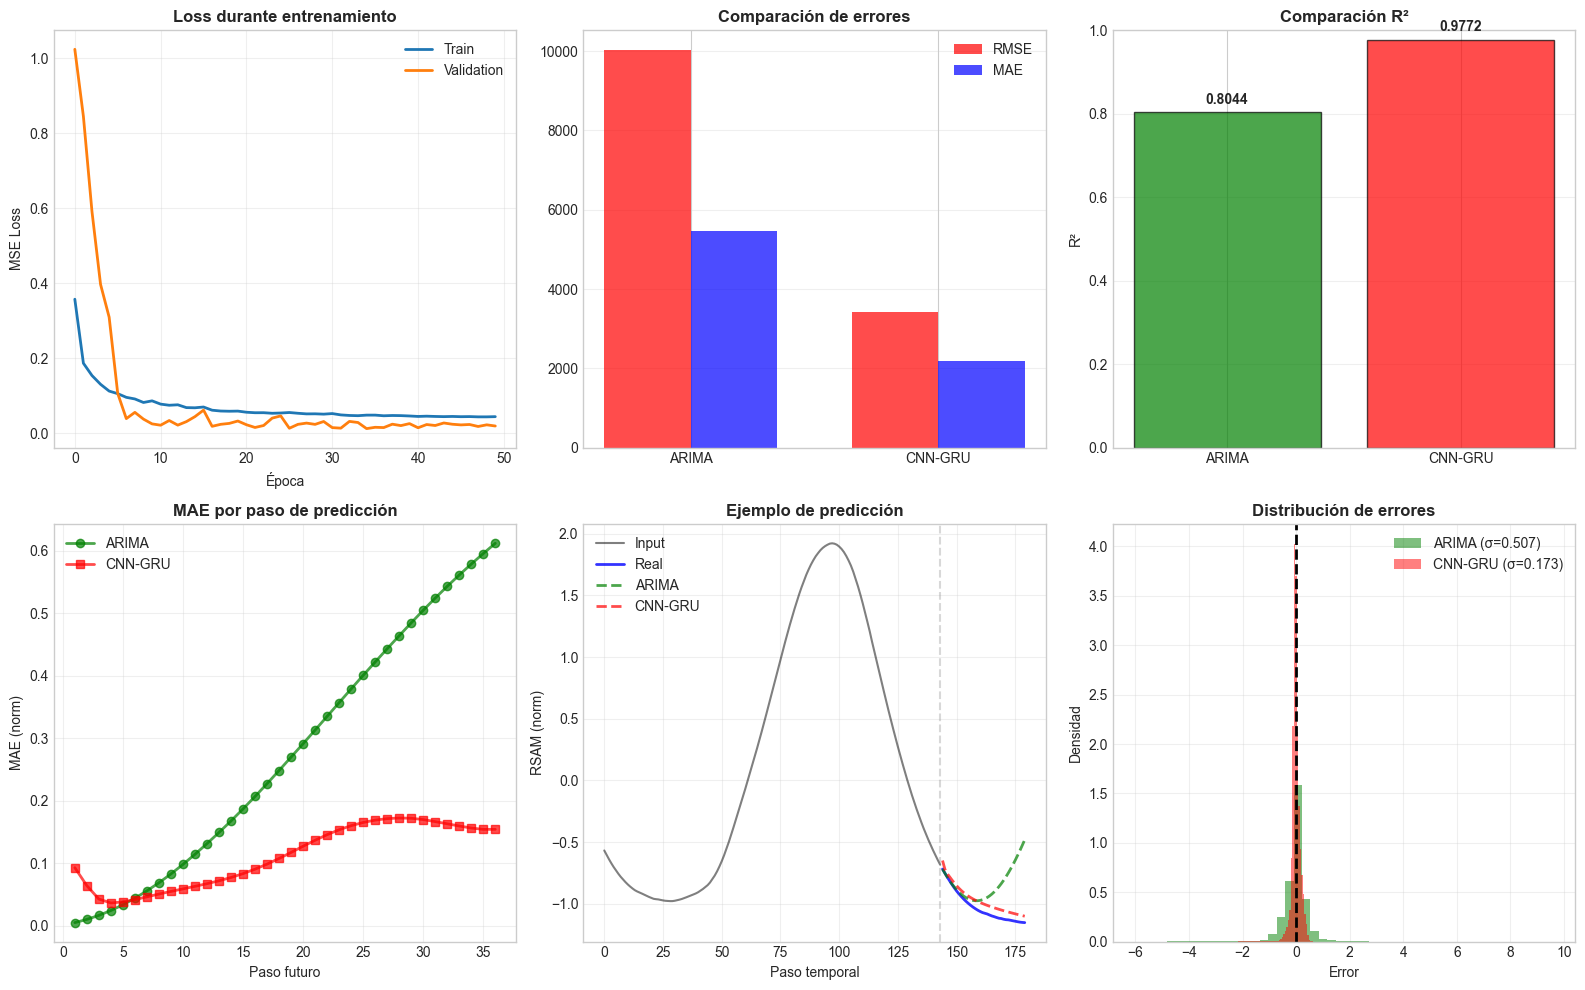


Mejora CNN-GRU vs ARIMA: 65.89% (RMSE)


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

ax = axes[0, 0]
ax.plot(history_base.history['loss'], label='Train', linewidth=2)
ax.plot(history_base.history['val_loss'], label='Validation', linewidth=2)
ax.set_title('Loss durante entrenamiento', fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
models = ['ARIMA', 'CNN-GRU']
rmse_vals = [metrics_arima['rmse'], metrics_base['rmse']]
mae_vals = [metrics_arima['mae'], metrics_base['mae']]
x = np.arange(len(models))
width = 0.35
ax.bar(x - width/2, rmse_vals, width, label='RMSE', alpha=0.7, color='red')
ax.bar(x + width/2, mae_vals, width, label='MAE', alpha=0.7, color='blue')
ax.set_title('Comparación de errores', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

ax = axes[0, 2]
r2_vals = [metrics_arima['r2'], metrics_base['r2']]
bars = ax.bar(models, r2_vals, color=['green', 'red'], alpha=0.7, edgecolor='black')
ax.set_title('Comparación R²', fontweight='bold')
ax.set_ylabel('R²')
ax.set_ylim(0, 1)
for bar, val in zip(bars, r2_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1, 0]
mae_arima = np.mean(np.abs(y_test - y_pred_arima), axis=0)
mae_base = np.mean(np.abs(y_test - y_pred_base), axis=0)
steps = range(1, output_steps + 1)
ax.plot(steps, mae_arima, 'o-', linewidth=2, label='ARIMA', color='green', alpha=0.7)
ax.plot(steps, mae_base, 's-', linewidth=2, label='CNN-GRU', color='red', alpha=0.7)
ax.set_title('MAE por paso de predicción', fontweight='bold')
ax.set_xlabel('Paso futuro')
ax.set_ylabel('MAE (norm)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
sample_idx = 0
X_sample = X_test[sample_idx, :, 0]
ax.plot(range(input_steps), X_sample, 'k-', linewidth=1.5, label='Input', alpha=0.5)
ax.axvline(input_steps-1, color='gray', linestyle='--', alpha=0.3)
future_x = range(input_steps, input_steps + output_steps)
ax.plot(future_x, y_test[sample_idx], 'b-', linewidth=2, label='Real', alpha=0.8)
ax.plot(future_x, y_pred_arima[sample_idx], 'g--', linewidth=2, label='ARIMA', alpha=0.7)
ax.plot(future_x, y_pred_base[sample_idx], 'r--', linewidth=2, label='CNN-GRU', alpha=0.7)
ax.set_title('Ejemplo de predicción', fontweight='bold')
ax.set_xlabel('Paso temporal')
ax.set_ylabel('RSAM (norm)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
errors_arima = y_test.flatten() - y_pred_arima.flatten()
errors_base = y_test.flatten() - y_pred_base.flatten()
ax.hist(errors_arima, bins=50, density=True, alpha=0.5,
        label=f'ARIMA (σ={errors_arima.std():.3f})', color='green')
ax.hist(errors_base, bins=50, density=True, alpha=0.5,
        label=f'CNN-GRU (σ={errors_base.std():.3f})', color='red')
ax.axvline(0, color='black', linestyle='--', linewidth=2)
ax.set_title('Distribución de errores', fontweight='bold')
ax.set_xlabel('Error')
ax.set_ylabel('Densidad')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'seq2seq_base_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

improvement = ((metrics_arima['rmse'] - metrics_base['rmse']) / metrics_arima['rmse']) * 100
print(f"\nMejora CNN-GRU vs ARIMA: {improvement:.2f}% (RMSE)")

## 6. Experimento 1 - Análisis de Robustez por Ventana Temporal

In [10]:
print(f"\n{'='*70}")
print("EXPERIMENTO 1: ROBUSTEZ POR VENTANA TEMPORAL")
print(f"{'='*70}")

results_window = {}

for config in CONFIG_NAMES:
    print(f"\nEvaluando configuración: {config.upper()}")
    
    X_train_cfg = datasets[config]['X_train']
    X_val_cfg = datasets[config]['X_val']
    X_test_cfg = datasets[config]['X_test']
    y_train_cfg = datasets[config]['y_train']
    y_val_cfg = datasets[config]['y_val']
    y_test_cfg = datasets[config]['y_test']
    input_steps_cfg = datasets[config]['input_steps']
    output_steps_cfg = datasets[config]['output_steps']
    
    model = build_seq2seq_cnn_gru(
        input_steps=input_steps_cfg,
        output_steps=output_steps_cfg,
        n_features=1,
        n_filters=64,
        kernel_size=3,
        encoder_units=64,
        decoder_units=64,
        n_conv_layers=2,
        dropout_rate=0.2
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]
    
    history = model.fit(
        X_train_cfg, y_train_cfg,
        validation_data=(X_val_cfg, y_val_cfg),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=0
    )
    
    y_pred = model.predict(X_test_cfg, batch_size=128, verbose=0).squeeze()
    metrics = calculate_metrics_seq(y_test_cfg, y_pred)
    print_metrics(metrics, f"CNN-GRU {config}")
    
    results_window[config] = {
        'metrics': metrics,
        'y_test': y_test_cfg,
        'y_pred': y_pred,
        'input_steps': input_steps_cfg,
        'output_steps': output_steps_cfg,
        'history': history
    }

print("\nExperimento 1 completado")


EXPERIMENTO 1: ROBUSTEZ POR VENTANA TEMPORAL

Evaluando configuración: SHORT

MÉTRICAS - CNN-GRU short
  RMSE (original):     1,967.38
  MAE (original):      1,477.33
  MAPE:                2.75%
  R²:                  0.9925
  RMSE (normalizado):  0.0998
  MAE (normalizado):   0.0749

Evaluando configuración: MEDIUM

MÉTRICAS - CNN-GRU medium
  RMSE (original):     3,086.75
  MAE (original):      1,932.78
  MAPE:                3.25%
  R²:                  0.9814
  RMSE (normalizado):  0.1566
  MAE (normalizado):   0.0980

Evaluando configuración: LONG

MÉTRICAS - CNN-GRU long
  RMSE (original):     4,572.51
  MAE (original):      2,817.76
  MAPE:                4.73%
  R²:                  0.9593
  RMSE (normalizado):  0.2320
  MAE (normalizado):   0.1429

Experimento 1 completado


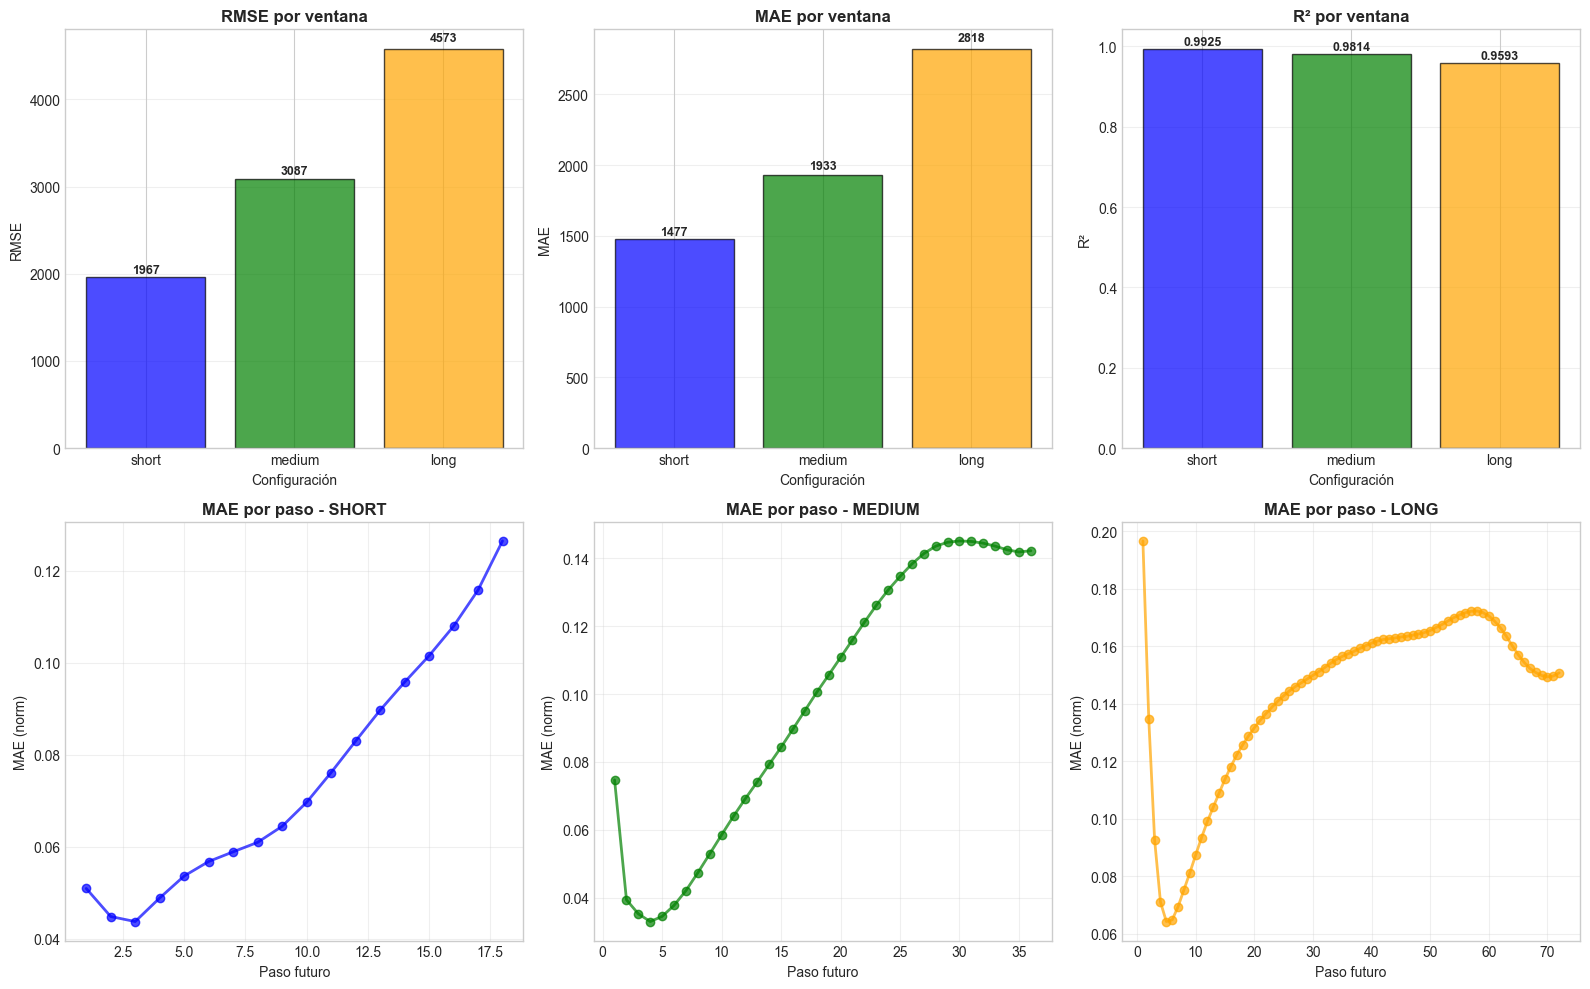

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics_names = ['RMSE', 'MAE', 'R²']
configs = CONFIG_NAMES

for idx, metric in enumerate(['rmse', 'mae', 'r2']):
    ax = axes[0, idx]
    vals = [results_window[c]['metrics'][metric] for c in configs]
    bars = ax.bar(configs, vals, alpha=0.7, color=['blue', 'green', 'orange'], edgecolor='black')
    ax.set_title(f'{metrics_names[idx]} por ventana', fontweight='bold')
    ax.set_xlabel('Configuración')
    ax.set_ylabel(metrics_names[idx])
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, vals):
        if metric == 'r2':
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
                    f'{val:.0f}', ha='center', fontsize=9, fontweight='bold')

for idx, config in enumerate(configs):
    ax = axes[1, idx]
    output_steps_cfg = results_window[config]['output_steps']
    mae_per_step = np.mean(np.abs(results_window[config]['y_test'] - 
                                   results_window[config]['y_pred']), axis=0)
    steps = range(1, output_steps_cfg + 1)
    ax.plot(steps, mae_per_step, 'o-', linewidth=2, color=['blue', 'green', 'orange'][idx], alpha=0.7)
    ax.set_title(f'MAE por paso - {config.upper()}', fontweight='bold')
    ax.set_xlabel('Paso futuro')
    ax.set_ylabel('MAE (norm)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'exp1_window_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Experimento 2 - Análisis de Robustez por Arquitectura

In [12]:
architectures = {
    'shallow': {
        'n_filters': 32,
        'encoder_units': 32,
        'decoder_units': 32,
        'n_conv_layers': 1,
        'dropout_rate': 0.2
    },
    'base': {
        'n_filters': 64,
        'encoder_units': 64,
        'decoder_units': 64,
        'n_conv_layers': 2,
        'dropout_rate': 0.2
    },
    'deep': {
        'n_filters': 64,
        'encoder_units': 128,
        'decoder_units': 128,
        'n_conv_layers': 3,
        'dropout_rate': 0.3
    },
    'wide': {
        'n_filters': 128,
        'encoder_units': 64,
        'decoder_units': 64,
        'n_conv_layers': 2,
        'dropout_rate': 0.2
    }
}

print("Arquitecturas definidas:")
for name, config in architectures.items():
    print(f"\n{name.upper()}:")
    for k, v in config.items():
        print(f"  {k}: {v}")

Arquitecturas definidas:

SHALLOW:
  n_filters: 32
  encoder_units: 32
  decoder_units: 32
  n_conv_layers: 1
  dropout_rate: 0.2

BASE:
  n_filters: 64
  encoder_units: 64
  decoder_units: 64
  n_conv_layers: 2
  dropout_rate: 0.2

DEEP:
  n_filters: 64
  encoder_units: 128
  decoder_units: 128
  n_conv_layers: 3
  dropout_rate: 0.3

WIDE:
  n_filters: 128
  encoder_units: 64
  decoder_units: 64
  n_conv_layers: 2
  dropout_rate: 0.2


In [13]:
print(f"\n{'='*70}")
print("EXPERIMENTO 2: ROBUSTEZ POR ARQUITECTURA (config=MEDIUM)")
print(f"{'='*70}")

results_arch = {}

config_name = 'medium'
X_train = datasets[config_name]['X_train']
X_val = datasets[config_name]['X_val']
X_test = datasets[config_name]['X_test']
y_train = datasets[config_name]['y_train']
y_val = datasets[config_name]['y_val']
y_test = datasets[config_name]['y_test']
input_steps = datasets[config_name]['input_steps']
output_steps = datasets[config_name]['output_steps']

for arch_name, arch_config in architectures.items():
    print(f"\nEntrenando arquitectura: {arch_name.upper()}")
    
    model = build_seq2seq_cnn_gru(
        input_steps=input_steps,
        output_steps=output_steps,
        n_features=1,
        kernel_size=3,
        **arch_config
    )
    
    print(f"Parámetros totales: {model.count_params():,}")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=0
    )
    
    y_pred = model.predict(X_test, batch_size=128, verbose=0).squeeze()
    metrics = calculate_metrics_seq(y_test, y_pred)
    print_metrics(metrics, arch_name)
    
    results_arch[arch_name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'history': history,
        'n_params': model.count_params(),
        'config': arch_config
    }

print("\nExperimento 2 completado")


EXPERIMENTO 2: ROBUSTEZ POR ARQUITECTURA (config=MEDIUM)

Entrenando arquitectura: SHALLOW
Parámetros totales: 12,961

MÉTRICAS - shallow
  RMSE (original):     4,184.24
  MAE (original):      2,731.77
  MAPE:                4.47%
  R²:                  0.9659
  RMSE (normalizado):  0.2123
  MAE (normalizado):   0.1386

Entrenando arquitectura: BASE
Parámetros totales: 88,001

MÉTRICAS - base
  RMSE (original):     3,647.84
  MAE (original):      2,394.00
  MAPE:                3.95%
  R²:                  0.9741
  RMSE (normalizado):  0.1850
  MAE (normalizado):   0.1214

Entrenando arquitectura: DEEP
Parámetros totales: 372,737

MÉTRICAS - deep
  RMSE (original):     3,553.68
  MAE (original):      2,609.40
  MAPE:                4.59%
  R²:                  0.9754
  RMSE (normalizado):  0.1803
  MAE (normalizado):   0.1324

Entrenando arquitectura: WIDE
Parámetros totales: 187,457

MÉTRICAS - wide
  RMSE (original):     3,595.13
  MAE (original):      2,364.41
  MAPE:              

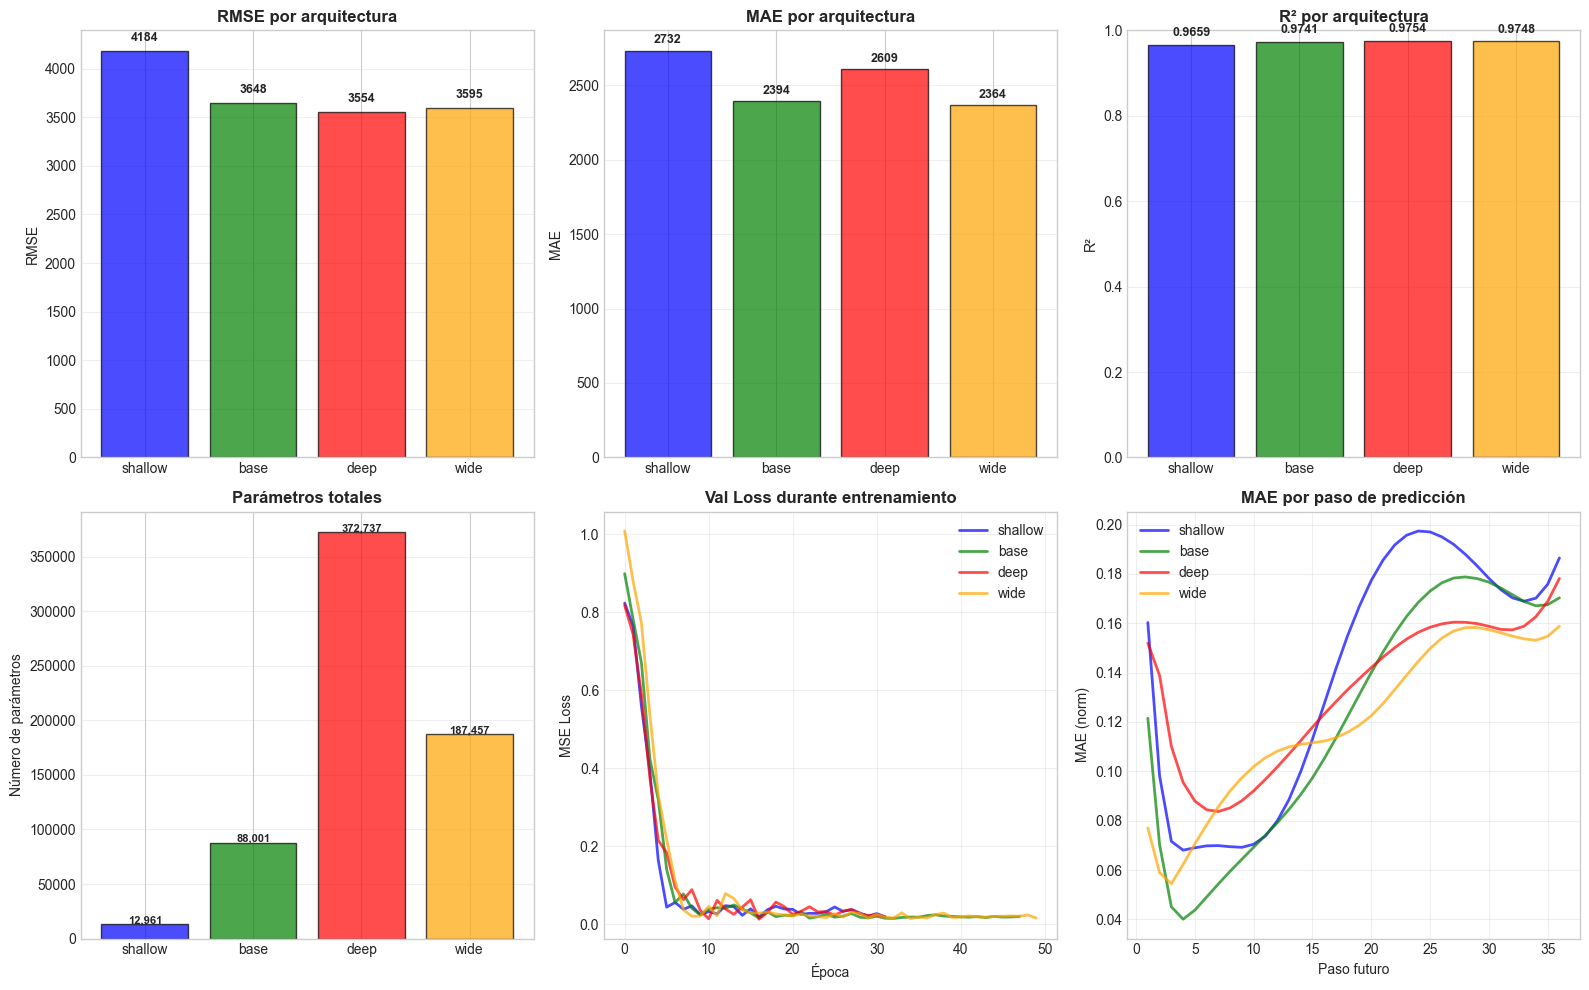

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

arch_names = list(architectures.keys())
colors = ['blue', 'green', 'red', 'orange']

ax = axes[0, 0]
rmse_vals = [results_arch[a]['metrics']['rmse'] for a in arch_names]
bars = ax.bar(arch_names, rmse_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('RMSE por arquitectura', fontweight='bold')
ax.set_ylabel('RMSE')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, rmse_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            f'{val:.0f}', ha='center', fontsize=9, fontweight='bold')

ax = axes[0, 1]
mae_vals = [results_arch[a]['metrics']['mae'] for a in arch_names]
bars = ax.bar(arch_names, mae_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('MAE por arquitectura', fontweight='bold')
ax.set_ylabel('MAE')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, mae_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:.0f}', ha='center', fontsize=9, fontweight='bold')

ax = axes[0, 2]
r2_vals = [results_arch[a]['metrics']['r2'] for a in arch_names]
bars = ax.bar(arch_names, r2_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('R² por arquitectura', fontweight='bold')
ax.set_ylabel('R²')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, r2_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}', ha='center', fontsize=9, fontweight='bold')

ax = axes[1, 0]
n_params = [results_arch[a]['n_params'] for a in arch_names]
bars = ax.bar(arch_names, n_params, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Parámetros totales', fontweight='bold')
ax.set_ylabel('Número de parámetros')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, n_params):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
            f'{val:,}', ha='center', fontsize=8, fontweight='bold')

ax = axes[1, 1]
for arch_name, color in zip(arch_names, colors):
    history = results_arch[arch_name]['history']
    ax.plot(history.history['val_loss'], label=arch_name, linewidth=2, color=color, alpha=0.7)
ax.set_title('Val Loss durante entrenamiento', fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
for arch_name, color in zip(arch_names, colors):
    mae_per_step = np.mean(np.abs(y_test - results_arch[arch_name]['y_pred']), axis=0)
    steps = range(1, output_steps + 1)
    ax.plot(steps, mae_per_step, '-', linewidth=2, label=arch_name, color=color, alpha=0.7)
ax.set_title('MAE por paso de predicción', fontweight='bold')
ax.set_xlabel('Paso futuro')
ax.set_ylabel('MAE (norm)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'exp2_architecture_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Tablas de Resultados

In [15]:
print("\n" + "="*80)
print("EXPERIMENTO 1: ROBUSTEZ POR VENTANA TEMPORAL")
print("="*80)

print(f"\n{'Config':<10} {'Input':<15} {'Output':<15} {'RMSE':>12} {'MAE':>12} {'R²':>10}")
print("-" * 80)

for config in CONFIG_NAMES:
    input_h = results_window[config]['input_steps'] // RSAM_PER_HOUR
    output_h = results_window[config]['output_steps'] // RSAM_PER_HOUR
    m = results_window[config]['metrics']
    
    print(f"{config.upper():<10} {input_h:>4}h ({results_window[config]['input_steps']:>3} pts) "
          f"{output_h:>4}h ({results_window[config]['output_steps']:>2} pts) "
          f"{m['rmse']:>12,.2f} {m['mae']:>12,.2f} {m['r2']:>10.4f}")


EXPERIMENTO 1: ROBUSTEZ POR VENTANA TEMPORAL

Config     Input           Output                  RMSE          MAE         R²
--------------------------------------------------------------------------------
SHORT        12h ( 72 pts)    3h (18 pts)     1,967.38     1,477.33     0.9925
MEDIUM       24h (144 pts)    6h (36 pts)     3,086.75     1,932.78     0.9814
LONG         48h (288 pts)   12h (72 pts)     4,572.51     2,817.76     0.9593


In [16]:
print("\n" + "="*100)
print("EXPERIMENTO 2: ROBUSTEZ POR ARQUITECTURA (config=MEDIUM)")
print("="*100)

print(f"\n{'Arquitectura':<15} {'Parámetros':>12} {'RMSE':>12} {'MAE':>12} {'MAPE':>10} {'R²':>10}")
print("-" * 100)

for arch_name in architectures.keys():
    m = results_arch[arch_name]['metrics']
    n_params = results_arch[arch_name]['n_params']
    
    print(f"{arch_name.upper():<15} {n_params:>12,} {m['rmse']:>12,.2f} {m['mae']:>12,.2f} "
          f"{m['mape']:>9.2f}% {m['r2']:>10.4f}")

print("-" * 100)
print(f"\nReferencia ARIMA(1,0,1): RMSE={metrics_arima['rmse']:,.2f}, "
      f"MAE={metrics_arima['mae']:,.2f}, R²={metrics_arima['r2']:.4f}")


EXPERIMENTO 2: ROBUSTEZ POR ARQUITECTURA (config=MEDIUM)

Arquitectura      Parámetros         RMSE          MAE       MAPE         R²
----------------------------------------------------------------------------------------------------
SHALLOW               12,961     4,184.24     2,731.77      4.47%     0.9659
BASE                  88,001     3,647.84     2,394.00      3.95%     0.9741
DEEP                 372,737     3,553.68     2,609.40      4.59%     0.9754
WIDE                 187,457     3,595.13     2,364.41      3.89%     0.9748
----------------------------------------------------------------------------------------------------

Referencia ARIMA(1,0,1): RMSE=10,023.37, MAE=5,451.51, R²=0.8044
